In [16]:
import json
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Helvetica"

In [2]:
import numpy as np
from nltk.corpus import wordnet as wn  # Assuming you're using WordNet

In [3]:
from nltk.corpus import sentiwordnet

In [4]:
figurative = {}
with open("chainnet_metaphor.json") as fin:
    data = json.load(fin)
    for item in data["content"]:
        figurative[item["to_sense"]] = 1

with open("chainnet_metonymy.json") as fin:
    data = json.load(fin)
    for item in data["content"]:
        figurative[item["to_sense"]] = 1
    

In [5]:
def get_pos_score(key):
    return sentiwordnet.senti_synset(key).pos_score()

In [6]:
def convert(sense_key):
    try:
        synset = wn.lemma_from_key(sense_key.split(";")[0]).synset()
        return synset.name()
    except:
        return None

def convert_to_lemma_key(synset_str):
    # Split the input string (e.g., "nice.a.01")
    lemma, pos, sense_num = synset_str.rsplit('.', 2)
    
    # Convert POS to WordNet format
    pos_map = {'n': 'n', 'v': 'v', 'a': 'a', 's': 's', 'r': 'r'}
    wn_pos = pos_map.get(pos, None)
    
    if wn_pos is None:
        raise ValueError("Invalid POS tag")

    # Convert sense number to integer and retrieve synset
    synset = wn.synsets(lemma, pos=wn_pos)[int(sense_num) - 1]
    
    # Convert to WordNet lemma key format
    lemma_name = synset.lemmas()[0].key()
    
    return lemma_name

In [7]:
convert("plane%1:06:01::")

'airplane.n.01'

In [8]:
semcor = pd.read_json("semcor.json.gz")
semcor["key"] = semcor["synsets"].apply(lambda x: x[0])
semcor["sense_key"] = semcor["key"].apply(convert_to_lemma_key)
masc = pd.read_json("masc.json.gz")
masc["lemma"] = masc["sense_key"].apply(lambda x: x.split("%")[0])
masc["key"] = masc["sense_key"].apply(convert)

• plane.n.03: a level of existence or development
• airplane.n.01: an aircraft that has a fixed wing and is powered by propellers or jets
• plane.n.02: (mathematics) an unbounded two-dimensional shape
• plane.v.01: cut or remove with or as if with a plane
• flat.s.01: having a surface without slope, tilt in which no part is higher or lower than another


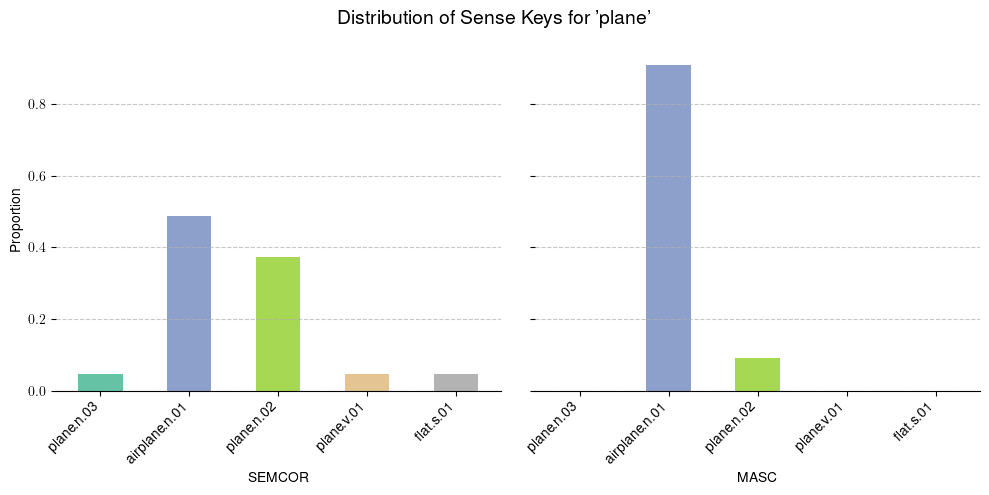

In [17]:
WORD = "plane"

fig, axis = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=False)

# Get unique sense keys from both datasets to align x-axis
all_keys = set(semcor[semcor.lemma == WORD]["key"]) | set(masc[masc.lemma == WORD]["key"])

# SEMCOR Plot
semcor_counts = semcor[semcor.lemma == WORD]["key"].value_counts(normalize=True)
semcor_counts = semcor_counts.reindex(all_keys, fill_value=0)  # Ensure same keys
cmap = plt.get_cmap("Set2", len(semcor_counts))
colors = [cmap(i) for i in range(len(semcor_counts))]

ax = semcor_counts.plot(kind="bar", color=colors, ax=axis[0], width=0.5)  # Set bar width
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xlabel("SEMCOR")
ax.set_ylabel("Proportion")
ax.set_xticklabels(semcor_counts.index, rotation=45, ha="right")

# MASC Plot
masc_counts = masc[masc.lemma == WORD]["key"].value_counts(normalize=True)
masc_counts = masc_counts.reindex(all_keys, fill_value=0)  # Ensure same keys
cmap = plt.get_cmap("Set2", len(masc_counts))
colors = [cmap(i) for i in range(len(masc_counts))]

ax = masc_counts.plot(kind="bar", color=colors, ax=axis[1], width=0.5)  # Set bar width
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xlabel("MASC")
ax.set_ylabel("Proportion")
ax.set_xticklabels(masc_counts.index, rotation=45, ha="right")

for i, key in enumerate(all_keys):
    try:
        definition = wn.synset(key).definition()
    except:
        definition = "Definition not found"
    print(f"• {key}: {definition}")

# Add title
fig.suptitle(f"Distribution of Sense Keys for '{WORD}'", fontsize=14)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig(f"{WORD}.pdf")

In [10]:
semcor_counts = semcor_counts.reset_index()
masc_counts = masc_counts.reset_index()

semcor_counts["score"] = semcor_counts["key"].apply(get_pos_score)
masc_counts["score"] = masc_counts["key"].apply(get_pos_score)

semcor_counts["figurative"] = semcor_counts["key"].apply(lambda x: convert_to_lemma_key(x) in figurative)
masc_counts["figurative"] = masc_counts["key"].apply(lambda x: convert_to_lemma_key(x) in figurative)
print(semcor_counts)
print(masc_counts)

             key  proportion  score  figurative
0     plane.n.03    0.046512  0.000        True
1  airplane.n.01    0.488372  0.000       False
2     plane.n.02    0.372093  0.000       False
3     plane.v.01    0.046512  0.000       False
4      flat.s.01    0.046512  0.375       False
             key  proportion  score  figurative
0     plane.n.03    0.000000  0.000        True
1  airplane.n.01    0.909091  0.000       False
2     plane.n.02    0.090909  0.000       False
3     plane.v.01    0.000000  0.000       False
4      flat.s.01    0.000000  0.375       False


In [11]:
print((semcor_counts["proportion"] > 0).sum())
print((masc_counts["proportion"] > 0).sum())

5
2


• heart.n.03: the courage to carry on
• heart.n.02: the hollow muscular organ located behind the sternum and between the lungs; its rhythmic contractions move the blood through the body
• heart.n.01: the locus of feelings and intuitions
• kernel.n.03: the choicest or most essential or most vital part of some idea or experience
• center.n.01: an area that is approximately central within some larger region
• heart.n.10: a playing card in the major suit that has one or more red hearts on it


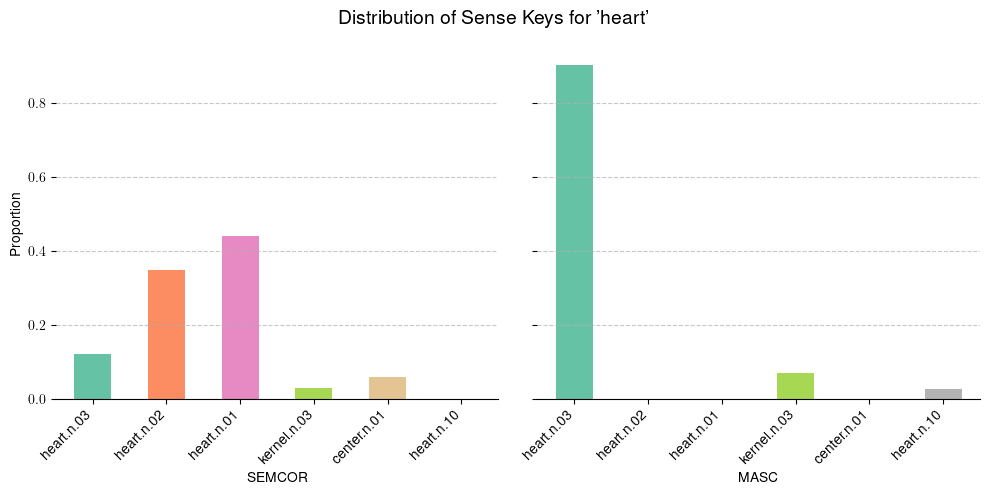

In [18]:
WORD = "heart"

fig, axis = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=False)

# Get unique sense keys from both datasets to align x-axis
all_keys = set(semcor[semcor.lemma == WORD]["key"]) | set(masc[masc.lemma == WORD]["key"])

# SEMCOR Plot
semcor_counts = semcor[semcor.lemma == WORD]["key"].value_counts(normalize=True)
semcor_counts = semcor_counts.reindex(all_keys, fill_value=0)  # Ensure same keys
cmap = plt.get_cmap("Set2", len(semcor_counts))
colors = [cmap(i) for i in range(len(semcor_counts))]

ax = semcor_counts.plot(kind="bar", color=colors, ax=axis[0], width=0.5)  # Set bar width
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xlabel("SEMCOR")
ax.set_ylabel("Proportion")
ax.set_xticklabels(semcor_counts.index, rotation=45, ha="right")

# MASC Plot
masc_counts = masc[masc.lemma == WORD]["key"].value_counts(normalize=True)
masc_counts = masc_counts.reindex(all_keys, fill_value=0)  # Ensure same keys
cmap = plt.get_cmap("Set2", len(masc_counts))
colors = [cmap(i) for i in range(len(masc_counts))]

ax = masc_counts.plot(kind="bar", color=colors, ax=axis[1], width=0.5)  # Set bar width
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xlabel("MASC")
ax.set_ylabel("Proportion")
ax.set_xticklabels(masc_counts.index, rotation=45, ha="right")

# Add text descriptions
for i, key in enumerate(all_keys):
    try:
        definition = wn.synset(key).definition()
    except:
        definition = "Definition not found"
    print(f"• {key}: {definition}")

# Add title
fig.suptitle(f"Distribution of Sense Keys for '{WORD}'", fontsize=14)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig(f"{WORD}.pdf")

In [13]:
semcor_counts = semcor_counts.reset_index()
masc_counts = masc_counts.reset_index()

semcor_counts["score"] = semcor_counts["key"].apply(get_pos_score)
masc_counts["score"] = masc_counts["key"].apply(get_pos_score)

semcor_counts["figurative"] = semcor_counts["key"].apply(lambda x: convert_to_lemma_key(x) in figurative)
masc_counts["figurative"] = masc_counts["key"].apply(lambda x: convert_to_lemma_key(x) in figurative)
print(semcor_counts)
print(masc_counts)

           key  proportion  score  figurative
0   heart.n.03    0.121212   0.25        True
1   heart.n.02    0.348485   0.00       False
2   heart.n.01    0.439394   0.00        True
3  kernel.n.03    0.030303   0.25        True
4  center.n.01    0.060606   0.00       False
5   heart.n.10    0.000000   0.00        True
           key  proportion  score  figurative
0   heart.n.03    0.901408   0.25        True
1   heart.n.02    0.000000   0.00       False
2   heart.n.01    0.000000   0.00        True
3  kernel.n.03    0.070423   0.25        True
4  center.n.01    0.000000   0.00       False
5   heart.n.10    0.028169   0.00        True


In [14]:
print((semcor_counts["proportion"] * semcor_counts["score"]).sum())
print((masc_counts["proportion"] * masc_counts["score"]).sum())

0.03787878787878788
0.24295774647887325


In [15]:
print((semcor_counts["proportion"] * semcor_counts["figurative"]).sum())
print((masc_counts["proportion"] * masc_counts["figurative"]).sum())

0.5909090909090908
1.0
